In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

In [2]:
WORLD_SIZE = 5#单元格阶数
A_POS = [0, 0]#A位置
A_PRIME_POS = [4, 4]#A理想位置
B_POS = [0, 3]#B位置
B_PRIME_POS = [4, 2]#B理想位置
DISCOUNT = 0.9#折扣gamma

In [3]:
# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTIONS_FIGS=[ '←', '↑', '→', '↓']


ACTION_PROB = 0.25

In [4]:
def step(state, action):
    if state == A_POS:
        return A_PRIME_POS, 10
    if state == B_POS:
        return B_PRIME_POS, 5

    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward

In [5]:
def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):

        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')
        

    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')

    ax.add_table(tb)

In [6]:
def draw_policy(optimal_values):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = optimal_values.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(optimal_values):
        next_vals=[]
        for action in ACTIONS:
            next_state, _ = step([i, j], action)
            next_vals.append(optimal_values[next_state[0],next_state[1]])

        best_actions=np.where(next_vals == np.max(next_vals))[0]
        val=''
        for ba in best_actions:
            val+=ACTIONS_FIGS[ba]
        
        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                loc='center', facecolor='white')

    # Row and column labels...
    for i in range(len(optimal_values)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                   edgecolor='none', facecolor='none')

    ax.add_table(tb)

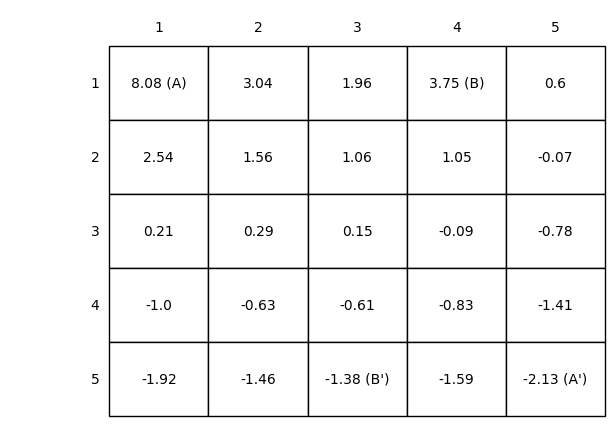

In [7]:
value = np.zeros((WORLD_SIZE, WORLD_SIZE))
while True:
    # keep iteration until convergence
    new_value = np.zeros_like(value)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            for action in ACTIONS:
                (next_i, next_j), reward = step([i, j], action)
                # bellman equation
                new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])
    if np.sum(np.abs(value - new_value)) < 1e-4:
        draw_image(np.round(new_value, decimals=2))
        plt.show()
        break
    value = new_value

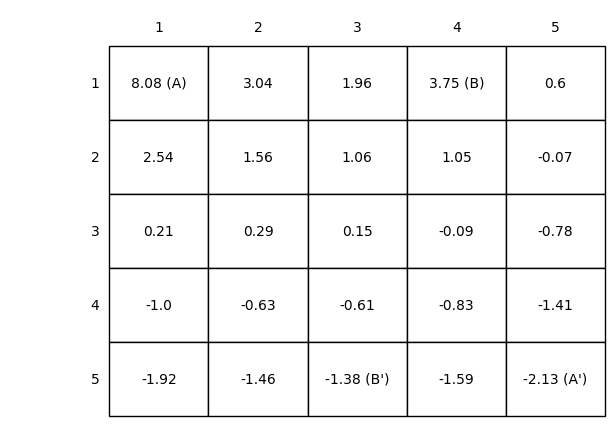

In [8]:
'''
Here we solve the linear system of equations to find the exact solution.
We do this by filling the coefficients for each of the states with their respective right side constant.
'''
A = -1 * np.eye(WORLD_SIZE * WORLD_SIZE)
b = np.zeros(WORLD_SIZE * WORLD_SIZE)
for i in range(WORLD_SIZE):
    for j in range(WORLD_SIZE):
        s = [i, j]  # current state
        index_s = np.ravel_multi_index(s, (WORLD_SIZE, WORLD_SIZE))
        for a in ACTIONS:
            s_, r = step(s, a)
            index_s_ = np.ravel_multi_index(s_, (WORLD_SIZE, WORLD_SIZE))

            A[index_s, index_s_] += ACTION_PROB * DISCOUNT
            b[index_s] -= ACTION_PROB * r

x = np.linalg.solve(A, b)
draw_image(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))
plt.show()

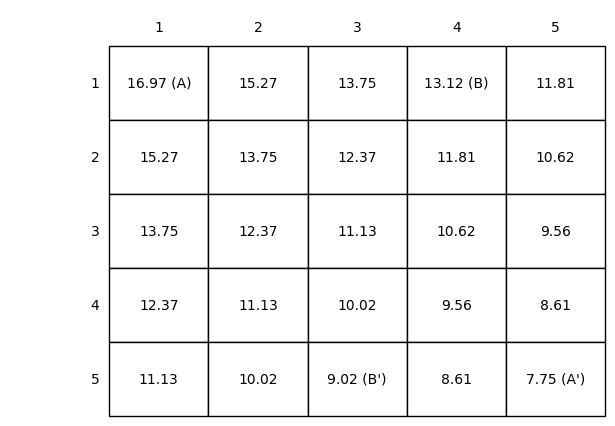

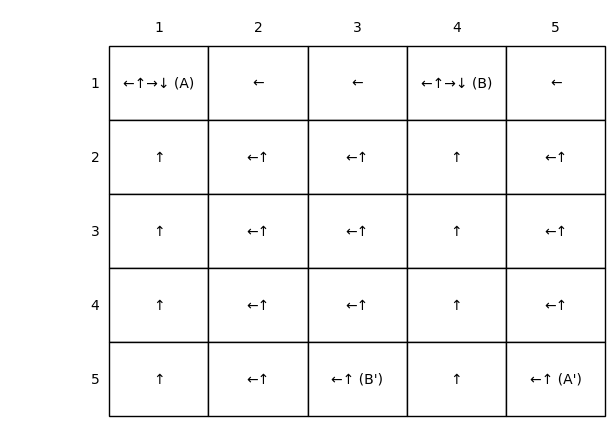

In [9]:
value = np.zeros((WORLD_SIZE, WORLD_SIZE))
while True:
    # keep iteration until convergence
    new_value = np.zeros_like(value)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            values = []
            for action in ACTIONS:
                (next_i, next_j), reward = step([i, j], action)
                # value iteration
                values.append(reward + DISCOUNT * value[next_i, next_j])
            new_value[i, j] = np.max(values)
    if np.sum(np.abs(new_value - value)) < 1e-4:
        draw_image(np.round(new_value, decimals=2))
        plt.show()
        draw_policy(new_value)
        plt.show()
        break
    value = new_value